# Fashion Mnist Dataset Artificial Neural Network Optimized with Dropout, Batch Normalization and L2 Regularization using Pytorch

## Import Libraries

In [1]:
# library to see model summary
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import kagglehub
import random
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Loading the Dataset

In [4]:
dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')
csv_file_path = f'{dataset_path}/fashion-mnist_train.csv'
df_train = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train.shape

(60000, 785)

In [7]:
csv_file_path = f'{dataset_path}/fashion-mnist_test.csv'
df_test = pd.read_csv(csv_file_path)

In [8]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test.shape

(10000, 785)

## Viewing the Random Image

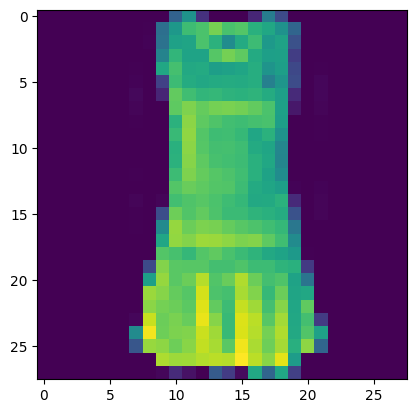

In [10]:
# train image
random_index = random.randint(0,len(df_train))
image = df_train.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

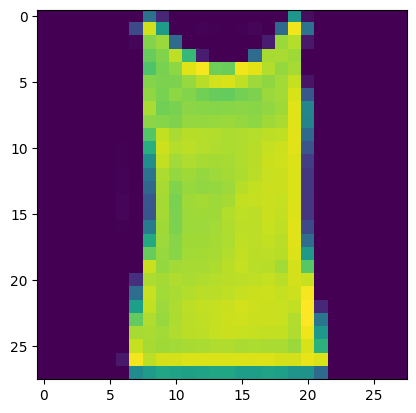

In [11]:
# test image
random_index = random.randint(0,len(df_test))
image = df_test.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

## Splitting the Dataset into Training and Testing Sets

In [12]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Crating Custom Dataset Class

In [14]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [15]:
train_datataset = CustomDataset(features=X_train, labels=y_train)
test_datataset = CustomDataset(features=X_test, labels=y_test)

In [16]:
train_dataloader = DataLoader(train_datataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_datataset, batch_size=32, shuffle=False, pin_memory=True)

## Model Building, Training and Evaluation

In [17]:
# crating model Class
class Model(nn.Module):

    def __init__(self, num_features):
        super().__init__()

        self.model = nn.Sequential(
            # first layer
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            # second layer
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            # output layer
            nn.Linear(64,10)
        )

    def forward(self, features):
        return self.model(features)

In [18]:
learning_rate=0.01
epochs=100

In [19]:
# creatind model object of Mode Class we creates above
model = Model(num_features=X_train.shape[1]).to(device)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer with weight decay for L2 regularization
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [20]:
print(summary(model))

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       100,480
│    └─BatchNorm1d: 2-2                  256
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       8,256
│    └─BatchNorm1d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0


In [21]:
# training loop
for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        y_pred = model(batch_features)
        
        # loss calculate
        loss = loss_function(y_pred, batch_labels)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # calculate loss for each batchs
        total_epoch_loss += loss.item()

    # average loss of batches
    avg_loss = total_epoch_loss/len(train_dataloader)

    print(f"Epoch: {epoch + 1}, Loss:{avg_loss}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1, Loss:0.7085606396834055
Epoch: 2, Loss:0.49362024029890694
Epoch: 3, Loss:0.45005779124101003
Epoch: 4, Loss:0.4235223362604777
Epoch: 5, Loss:0.406793281630675
Epoch: 6, Loss:0.38917511727015175
Epoch: 7, Loss:0.3765886586924394
Epoch: 8, Loss:0.36757534701625505
Epoch: 9, Loss:0.35828062150080997
Epoch: 10, Loss:0.35134675857226055
Epoch: 11, Loss:0.3426542981803417
Epoch: 12, Loss:0.33705057075421013
Epoch: 13, Loss:0.3305596866965294
Epoch: 14, Loss:0.32933587764104205
Epoch: 15, Loss:0.32096829588810605
Epoch: 16, Loss:0.31407639480431876
Epoch: 17, Loss:0.31169310909112297
Epoch: 18, Loss:0.3065443840901057
Epoch: 19, Loss:0.3019309866209825
Epoch: 20, Loss:0.2976115877012412
Epoch: 21, Loss:0.29408073417544367
Epoch: 22, Loss:0.29090536364714303
Epoch: 23, Loss:0.288375653698047
Epoch: 24, Loss:0.28401889052788415
Epoch: 25, Loss:0.28083428528706234
Epoch: 26, Loss:0.2777075629134973
Epoch: 27, Loss:0.2740321331421534
Epoch: 28, Loss:0.27247149078051247
Epoch: 29, Loss

In [22]:
# setting model to evaluation mode
model.eval()

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in test_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Test Data: {(correct/total)*100}%")

Accuracy on Test Data: 89.52%


In [24]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Train Data: {(correct/total)*100}%")

Accuracy on Train Data: 95.58833333333332%
